# Backtest: validation on historical data

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of time series validation using backtest module of ETNA library.

**Table of Contents**

* [What is backtest and how it works](#chapter1)  
* [How to run a validation](#chapter2)
* [Validation visualisation](#chapter3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.metrics.base import MetricAggregationMode
from etna.pipeline import Pipeline
from etna.models.base import Model
from etna.models.prophet import ProphetModel
from etna.transforms.base import Transform
from etna.analysis.plotters import plot_backtest

### 1. What is backtest and how it works <a class="anchor" id="chapter1"></a>

Backtest is a predictions and validation pipeline build on historical data to make a legitimate retrotest of your model.

<b>How does it work?</b>

When constructing a forecast using Models and further evaluating the prediction metrics, we measure the quality at one time interval, designated as test.

Backtest allows you to simulate how the model would work in the past:

* selects a period of time in the past

* builds a model using the selected interval as a training sample

* predicts the value on the test interval and calculates metrics.

The image shows a plot of the backtest pipeline with `n_folds = 3`.

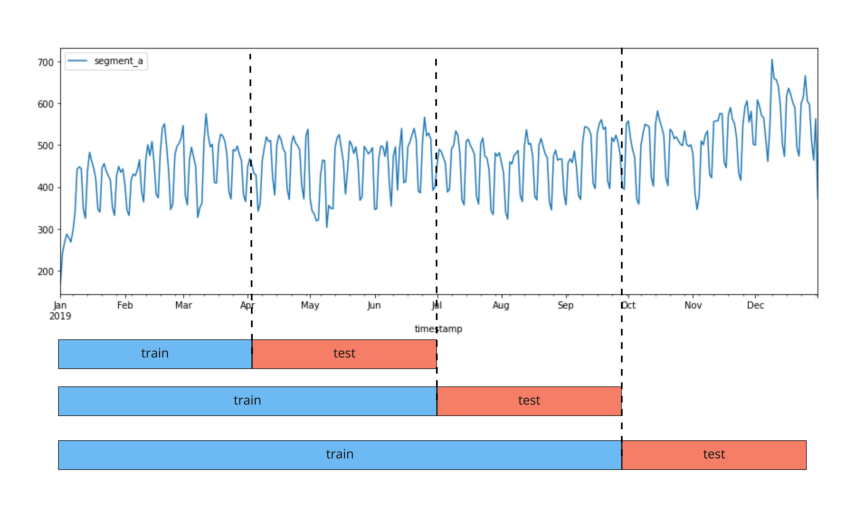

In [2]:
img = plt.imread("./assets/backtest/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis('off')
_ = plt.imshow(img)

Below we will call a fold the train + test pair, for which training and forecasting is performed.

In [3]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == 'segment_a']
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the spacial data structure TSDataset. So, before starting the EDA, we need to convert the classical DataFrame to TSDataset.

In [4]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq='D')

#### Let's get a look on series

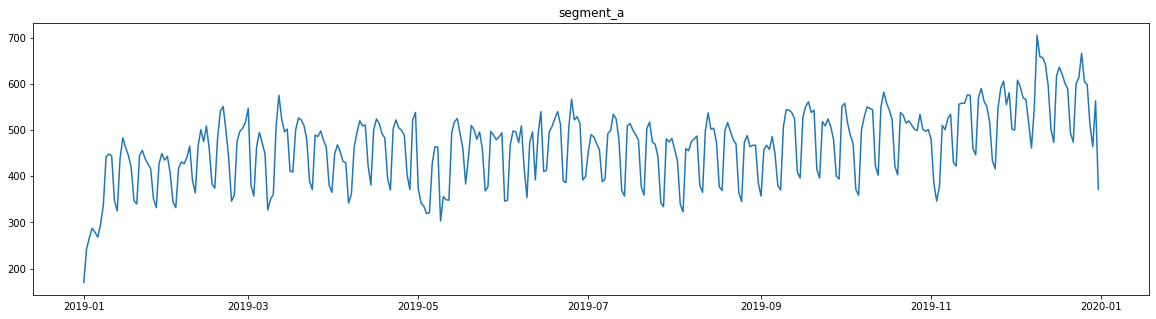

In [5]:
ts.plot(segments=['segment_a'])

### 2. How to run a validation <a class="anchor" id="chapter2"></a>

For an easy start let's create a Prophet model

In [6]:
horizon = 31 # Set the horizon for predictions
model = ProphetModel() # Create a model
transforms = [] #A list of transforms -  we will not use any of them

### `Pipeline` <a class="anchor" id="section_2_1"></a>

Now let's create an instance of `Pipeline`.

In [7]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

We are going to run `backtest` method for it. As a result, three dataframes will be returned: 
* dataframe with metrics for each fold and each segment, 
* dataframe with predictions, 
* dataframe with information about folds.

In [8]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE()]
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_season

In [9]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,21.027199,673.267770,4.842942,0
0,segment_a,29.890191,1297.367635,6.254610,1
0,segment_a,35.722208,1972.422737,7.368013,2
0,segment_a,32.022084,1873.437423,6.474391,3
0,segment_a,55.281494,4903.591315,10.060456,4


In [10]:
forecast_df.head()

segment      segment_a            
feature         target fold_number
timestamp                         
2019-07-30  506.605894           0
2019-07-31  495.447819           0
2019-08-01  486.188955           0
2019-08-02  473.631188           0
2019-08-03  390.174094           0

In [11]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,0
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,1
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,2
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,3
0,2019-01-01,2019-11-30,2019-12-01,2019-12-31,4


You can additionally get the metrics averaged over folds:

In [17]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, 
    metrics=[MAE(), MSE(), SMAPE()], 
    aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_season

In [18]:
metrics_df

,segment,MAE,MSE,SMAPE
0,segment_a,34.788635,2144.017376,7.000082


### 3. Validation visualisation <a class="anchor" id="chapter3"></a>

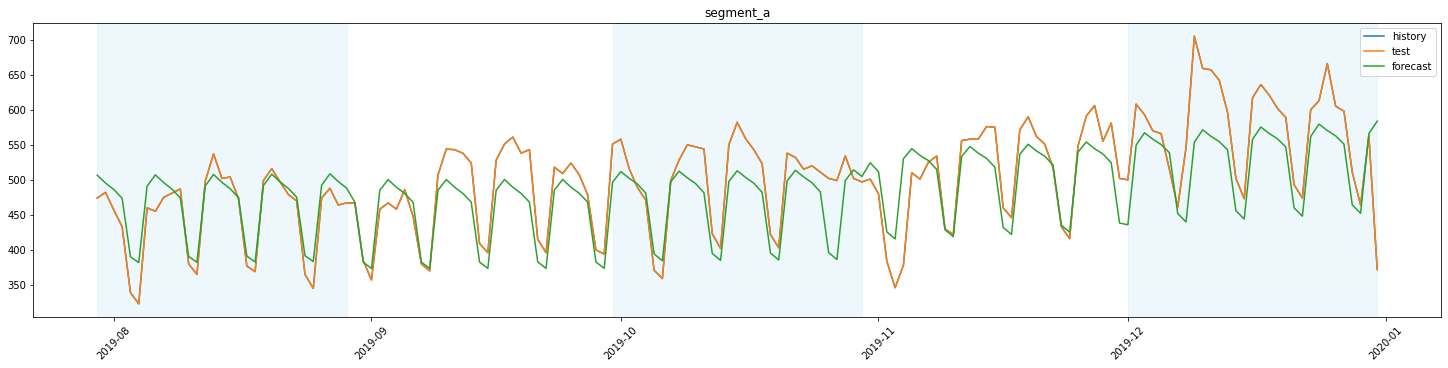

In [19]:
plot_backtest(forecast_df, ts)

Let's see how the data looked before the backtest -  we specify `history_len`.

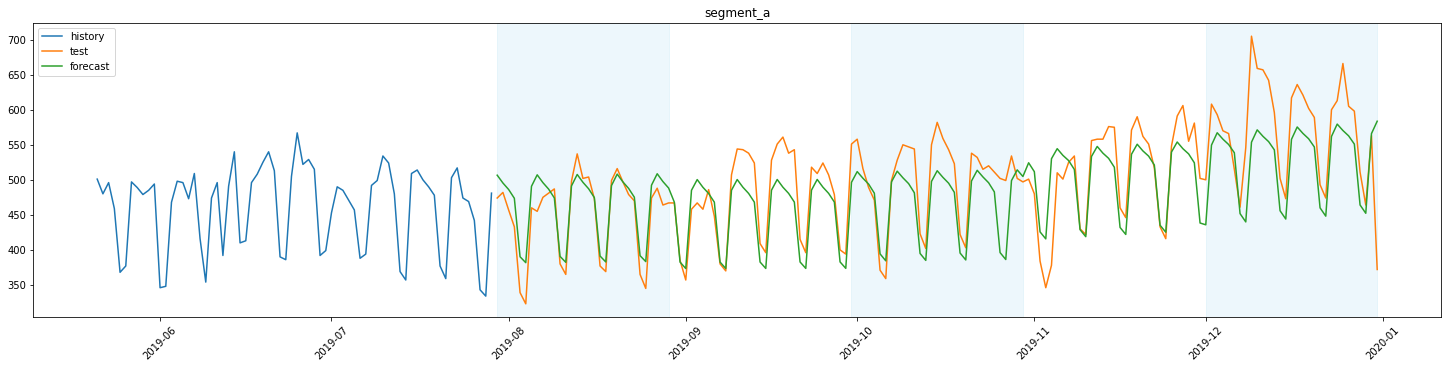

In [20]:
plot_backtest(forecast_df, ts, history_len=70)

That's all for this notebook. More features you can find in our documentation!